<a href="https://colab.research.google.com/github/riken01/DS-labs/blob/master/seed_iv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 作业4：基于DANN的四类情绪分类

## 引入依赖
使用pytorch库实现DANN域适应模型。

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import functools
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Function

## 读取数据
遍历读取SEED-IV文件夹下的所有文件，并对data进行reshape，便于后续处理。将读取的数据存放在train_data,train_label,test_data,test_label四个dictionary中，其中train_data[i][j]表示在第i次试验中第j名被试的train数据。

In [ ]:
src_path = '/content/drive/MyDrive/Colab Notebooks/SEED-IV/'
sessions = [1, 2, 3]
train_datas = {}
train_labels = {}
test_datas = {}
test_labels = {}
for session in sessions:
  session_train_data = {}
  session_train_label = {}
  session_test_data = {}
  session_test_label = {}
  folder_path = src_path + str(session)
  # 定义当前session下所有子文件夹的路径
  subfolder_names = os.listdir(folder_path)
  # 遍历当前session下所有子文件夹
  for subfolder_name in subfolder_names:
    # 获取被试编号
    participant_id = int(subfolder_name.split('_')[0])
    #从文件读取数据
    subfolder_path = os.path.join(folder_path, subfolder_name)
    train_X = np.load(os.path.join(subfolder_path, 'train_data.npy'))
    session_train_label[participant_id - 1] = np.load(os.path.join(subfolder_path, 'train_label.npy'))
    test_X = np.load(os.path.join(subfolder_path, 'test_data.npy'))
    session_test_label[participant_id - 1] = np.load(os.path.join(subfolder_path, 'test_label.npy'))
    #对数据reshape
    r_train_X = train_X.reshape((len(train_X), -1))
    r_test_X = test_X.reshape((len(test_X), -1))
    session_train_data[participant_id - 1] = r_train_X
    session_test_data[participant_id - 1] = r_test_X
  train_datas[session] = session_train_data
  train_labels[session] = session_train_label
  test_datas[session] = session_test_data
  test_labels[session] = session_test_label

## 数据处理

被试独立需要将被试3个session的数据拼接进行留一交叉验证。每次取14名被试做训练集，1名被试做测试集，直到所有被试都轮流被当作测试集，最终取平均准确率。

将每个tester的三个session的train和test数据连接在一起，一共获得15组data-label数据，存放在test_train_datas和test_train_labels两个dictionary中。使用getData(i)函数可以获得第i个被试的所有session连接的数据。

In [ ]:
def getData(column):
  X_train = train_datas[1][column]
  X_test = test_datas[1][column]
  y_train = train_labels[1][column]
  y_test = test_labels[1][column]
  for i in range(2, 4):
    X_train = np.append(X_train, train_datas[i][column], axis=0)
    X_test = np.append(X_test, test_datas[i][column], axis=0)
    y_train = np.append(y_train, train_labels[i][column])
    y_test = np.append(y_test, test_labels[i][column])

  return np.append(X_train,X_test,axis=0), np.append(y_train, y_test)

## 构建域标签数据集
对每一个被试分配域标签，域标签为被试id-1（0～14）。

In [ ]:
def dependentData(column):
  tester, tester_label = getData(column)
  test = tester[10:]
  test_label = tester_label[10:]
  test_domain = np.array([column]*len(test_label), dtype=int)
  train = tester[:10]
  label = tester_label[:10]
  domain = np.array([column]*len(label), dtype=int)
  for i in range(15):
    if i == column:
      continue

    X_train, y_train = getData(i)
    if len(train)==0:
      train = X_train
    else:
      train = np.append(train, X_train, axis=0)

    if len(test)==0:
      label = y_train
    else:
      label = np.append(label, y_train)

    domain = np.append(domain, [i]*len(y_train))

  return train, label, domain, test, test_label, test_domain

In [ ]:
# 将数据使用DataLoader转化成输入模型的torch变量
def getDataLoader(i, batch_size):
  # 将除了tester之外数据连接成为train_data
  X_train, y_train, d_train, X_test, y_test, d_test = dependentData(i)

  X_train = torch.from_numpy(X_train)
  X_test = torch.from_numpy(X_test)
  X_train = X_train.to(torch.float32)
  X_test = X_test.to(torch.float32)

  y_train = torch.from_numpy(y_train).long()
  y_test = torch.from_numpy(y_test).long()

  d_train = torch.from_numpy(d_train).long()
  d_test = torch.from_numpy(d_test).long()

  train_data_set = TensorDataset(X_train, y_train, d_train)
  train_data_loader = DataLoader(dataset=train_data_set, batch_size=batch_size, shuffle=True)

  test_data_set = TensorDataset(X_test, y_test, d_test)
  test_data_loader = DataLoader(dataset=test_data_set, batch_size=batch_size, shuffle=False)
  return train_data_loader, test_data_loader

## 一、域适应

### 1.模型构建
使用全连接层实现DANN，定义模型的三个部分：特征提取器，标签分类器和域分类器。其中特征提取器是一个两层的全连接层，将源域和目标域数据转换为高层次的特征。标签分类器是一个单层的全连接层，用于将特征表示映射到标签空间。域分类器是一个单层的全连接层，是一个输出为域标签的二元分类器，用于确定输入数据是来自源域还是目标域。

同时，定义梯度反转层ReversalLayer。

DANN模型参考论文公开代码实现。
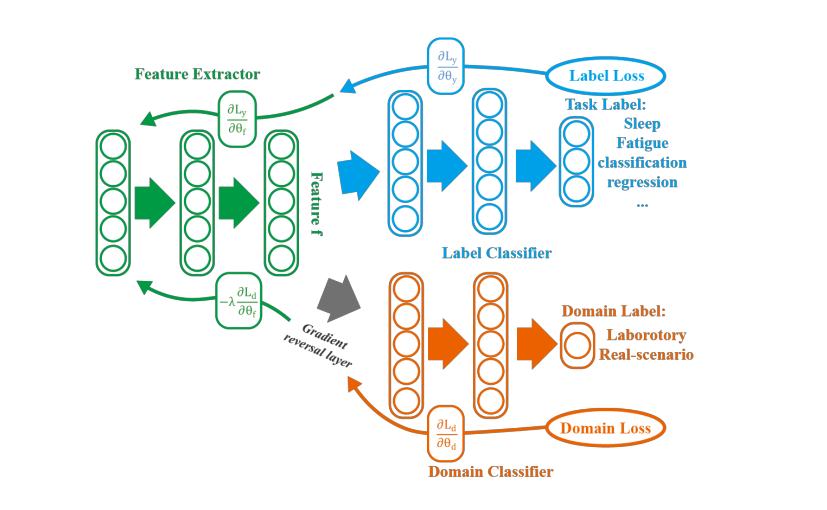

In [ ]:
# 梯度反转层
class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

# DANN模型
class DANNModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 特征提取器
        self.feature = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=310, nhead=5), num_layers=3)

        # 标签分类器
        self.class_classifier = nn.Sequential()
        self.class_classifier.add_module('c_fc1', nn.Linear(310, 128))
        self.class_classifier.add_module('c_bn1', nn.BatchNorm1d(128))
        self.class_classifier.add_module('c_relu1', nn.ReLU(True))
        self.class_classifier.add_module('c_drop1', nn.Dropout())
        self.class_classifier.add_module('c_fc2', nn.Linear(128, 64))
        self.class_classifier.add_module('c_bn2', nn.BatchNorm1d(64))
        self.class_classifier.add_module('c_relu2', nn.ReLU(True))
        self.class_classifier.add_module('c_fc3', nn.Linear(64, 4))
        self.class_classifier.add_module('c_softmax', nn.LogSoftmax(dim=1))

        # 域分类器
        self.domain_classifier = nn.Sequential()
        self.domain_classifier.add_module('c_fc1', nn.Linear(310, 128))
        self.domain_classifier.add_module('c_bn1', nn.BatchNorm1d(128))
        self.domain_classifier.add_module('c_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('c_drop1', nn.Dropout())
        self.domain_classifier.add_module('c_fc2', nn.Linear(128, 64))
        self.domain_classifier.add_module('c_bn2', nn.BatchNorm1d(64))
        self.domain_classifier.add_module('c_relu2', nn.ReLU(True))
        self.domain_classifier.add_module('c_fc3', nn.Linear(64, 15))
        self.domain_classifier.add_module('d_softmax', nn.LogSoftmax(dim=1))

    def forward(self, input_data, alpha):
        feature = self.feature(input_data)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.class_classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)

        return class_output, domain_output

### 2. 模型设置
设置学习率，epoch数，batch大小等超参数，定义weight初始化。

In [ ]:
# initial Linear weight
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

# 超参数
batch_size = 256
learning_rate = 1e-5
num_epochs = 30

### 3.模型训练

将test数据中的域分类部分也作为训练时学习的数据使用,标签不可视。

In [ ]:
def runDANN(person):
  train_data_loader, test_data_loader = getDataLoader(person, batch_size)
  model = DANNModel()
  model.apply(weights_init)
  torch.manual_seed(13)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  max_acc = 0
  earlyflag = 0
  for epoch in range(num_epochs):
    len_dataloader = len(train_data_loader)
    data_iter = iter(train_data_loader)
    '''iter in each epoch'''
    for i in range(len_dataloader):
        '''set alpha value'''
        p = float(i + epoch * len_dataloader) / num_epochs / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1
        '''load data from in-epoch iter'''
        data, label, domain = next(data_iter)
        data=data.float()
        label = label.long()
        domain = domain.long()
        '''forward and get output'''
        class_output, domain_output = model(input_data=data, alpha=alpha)
        domain_output = domain_output.float()
        class_output = class_output.float()

        '''calculate loss'''
        criterion1 = nn.CrossEntropyLoss()
        criterion2 = nn.CrossEntropyLoss()
        domain_loss = criterion2(domain_output, domain)
        classifier_loss = criterion1(class_output, label)
        '''set loss hyper'''
        hyper = 0.1
        all_loss = classifier_loss + hyper*domain_loss
        '''calculate grad by loss and do backward'''
        optimizer.zero_grad()
        all_loss.backward()
        optimizer.step()
    len_dataloader = len(test_data_loader)
    data_iter = iter(test_data_loader)
    '''iter in each epoch'''
    for i in range(len_dataloader):
        '''set alpha value'''
        p = float(i + epoch * len_dataloader) / num_epochs / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1
        '''load data from in-epoch iter'''
        data, label, domain = next(data_iter)
        data=data.float()
        domain = domain.long()
        '''forward and get output'''
        class_output, domain_output = model(input_data=data, alpha=alpha)
        domain_output = domain_output.float()

        '''calculate loss'''
        criterion2 = nn.CrossEntropyLoss()
        domain_loss = criterion2(domain_output, domain)
        '''set loss hyper'''
        hyper = 0.1
        all_loss = hyper*domain_loss
        '''calculate grad by loss and do backward'''
        optimizer.zero_grad()
        all_loss.backward()
        optimizer.step()

    '''eval after training'''
    with torch.no_grad():
      alpha = 0
      tlen_dataloader = len(test_data_loader)
      acc_label = 0
      acc_domain = 0
      total = 0
      for x, y, z in test_data_loader:
        label, domain = model(input_data=x, alpha=alpha)

        label = torch.argmax(label, 1).cpu().numpy()
        domain = torch.argmax(domain, 1).cpu().numpy()

        acc_label += np.sum(np.array(label) == y.numpy())
        acc_domain += np.sum(np.array(domain) == z.numpy())
        total += len(label)
      acc = 1.0*acc_label/total
      if acc > max_acc:
        max_acc = acc
        earlyflag = 0
      else:
        earlyflag = earlyflag + 1
        if earlyflag >= 5:
          print('early stops')
          print(f'[DANN] Epoch:{epoch+1}/{num_epochs}  Label_Acc:{max_acc} Loss:{all_loss.data} Role:{person+1}')
          return max_acc
  return max_acc


In [ ]:
acc_all = []
for i in range(15):
  acc = runDANN(i)
  acc_all.append(acc)
print(acc_all)

early stops
[DANN] Epoch:28/30  Label_Acc:0.5006012024048097 Loss:0.2565601170063019 Role:1
early stops
[DANN] Epoch:18/30  Label_Acc:0.47374749498998 Loss:0.2718212902545929 Role:2
early stops
[DANN] Epoch:17/30  Label_Acc:0.4356713426853707 Loss:0.2716960906982422 Role:3
early stops
[DANN] Epoch:22/30  Label_Acc:0.5623246492985972 Loss:0.2651765048503876 Role:4
early stops
[DANN] Epoch:21/30  Label_Acc:0.4729458917835671 Loss:0.27270957827568054 Role:5
early stops
[DANN] Epoch:24/30  Label_Acc:0.6112224448897795 Loss:0.25607192516326904 Role:7
early stops
[DANN] Epoch:14/30  Label_Acc:0.42925851703406814 Loss:0.2466161549091339 Role:8
early stops
[DANN] Epoch:25/30  Label_Acc:0.4977955911823647 Loss:0.2488965541124344 Role:9
early stops
[DANN] Epoch:15/30  Label_Acc:0.4372745490981964 Loss:0.2685454189777374 Role:10
early stops
[DANN] Epoch:23/30  Label_Acc:0.3867735470941884 Loss:0.26306745409965515 Role:11
early stops
[DANN] Epoch:28/30  Label_Acc:0.46012024048096195 Loss:0.2680122

In [ ]:
print(np.mean(acc_all))

0.48293921175684706


DANN取得平均准确率44.43%。

## 二、对比与分析

### 1. 与其它模型的被试独立比较
将DANN结果与作业2、3中的SVM和CNN的被试独立分类结果进行比较，结果如下图：

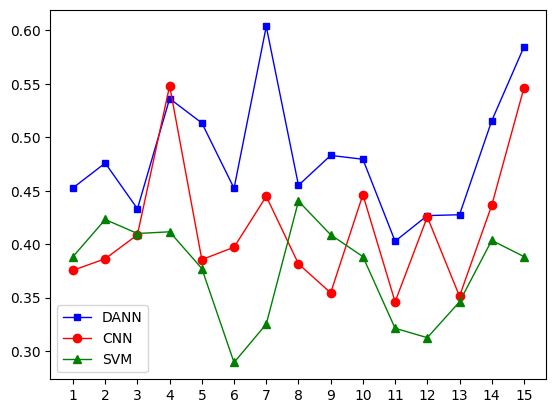

In [ ]:
acc_SVM = [0.3884, 0.4231, 0.4100, 0.4116, 0.3772, 0.2894, 0.3253, 0.4403, 0.4088, 0.3884, 0.3214, 0.3126, 0.3461, 0.4036, 0.3884]
acc_CNN = [0.3756, 0.3864, 0.4088, 0.5481, 0.3856, 0.3972, 0.4447, 0.3816, 0.3545, 0.4463, 0.3461, 0.4255, 0.3513, 0.4363, 0.5461]
acc_DANN = [0.4894, 0.5154, 0.4403, 0.5241, 0.4499, 0.3840, 0.5844, 0.4471, 0.4164, 0.3745, 0.3557, 0.3952, 0.4040, 0.4874, 0.3964]
acc_DAT = [0.45269461077844314, 0.47584830339321355, 0.43313373253493015, 0.536127744510978, 0.513373253493014, 0.45229540918163674, 0.6035928143712574, 0.4550898203592814, 0.48303393213572854, 0.47944111776447107, 0.4027944111776447, 0.42674650698602795, 0.4275449101796407, 0.5153692614770459, 0.5844311377245509]

x = [i for i in range(1, 16)]

plt.plot(x, acc_all, lw=1, c='blue', marker='s', ms=4, label='DANN')  # 绘制y1
plt.plot(x, acc_CNN, lw=1, c='red', marker='o', label='CNN')  # 绘制y2
plt.plot(x, acc_SVM, lw=1, c='green', marker='^', label='SVM')  # 绘制y3
plt.plot(x, acc_DAT, lw=1, c='orange', marker='+', label='DANN')  # 绘制y4

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt-style
plt.xticks(x)  # x轴的刻度

plt.legend(loc=3)  # 图例
plt.show()

图中可见DANN的整体效果比CNN和SVM都要更好一些，平均准确率达到了44.43%，高于SVM的37.56%和CNN的41.56%。15个被试中，有10个分类器都取得了最优效果，而CNN有5个分类器达到最优，SVM一个也没有。

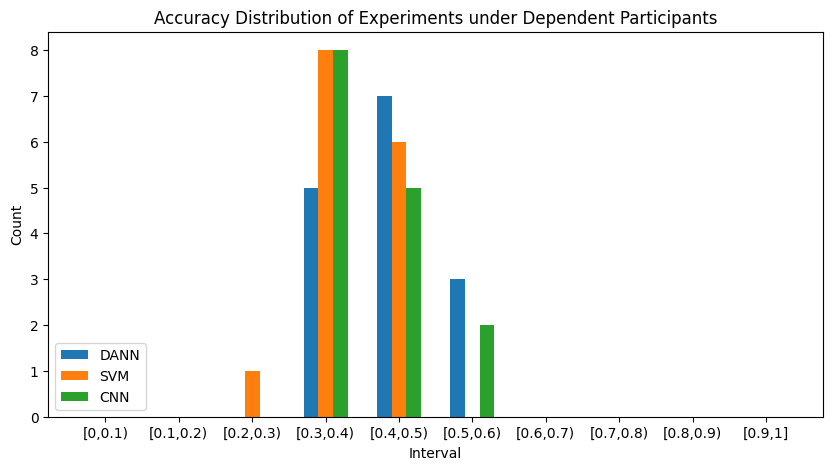

In [ ]:
# 将数据分成10个区间
bins = [0, 0.1, 0.2, 0.3, 0.4,0.5, 0.6,0.7, 0.8, 0.9, 1]

x = np.arange(len(bins)-1)
total_width, n = 0.6, 3

width = total_width / n
x = x - (total_width - width) / 2
# 计算不同区间的概率分布
counts = [sum(1 for j in range(len(acc_all)) if bins[i] <= acc_all[j] <
bins[i+1]) for i in range(len(bins)-1)]
counts2 = [sum(1 for j in range(len(acc_SVM)) if bins[i] <= acc_SVM[j] <
bins[i+1]) for i in range(len(bins)-1)]
counts3 = [sum(1 for j in range(len(acc_CNN)) if bins[i] <= acc_CNN[j] <
bins[i+1]) for i in range(len(bins)-1)]
# 绘制累积柱状图
plt.figure(figsize=(10, 5))
plt.bar(x, counts, label="DANN", width = width)
plt.bar(x + width, counts2, label="SVM", width = width)
plt.bar(x + 2*width, counts3, label="CNN", width = width)
plt.xticks(range(len(bins)-1), ['[0,0.1)', '[0.1,0.2)', '[0.2,0.3)',
'[0.3,0.4)', '[0.4,0.5)','[0.5,0.6)', '[0.6,0.7)', '[0.7,0.8)',
'[0.8,0.9)', '[0.9,1]'])
plt.xlabel('Interval')
plt.ylabel('Count')
plt.title('Accuracy Distribution of Experiments under Dependent Participants')
plt.legend(loc=3)  # 图例
plt.show()
# 被试独立数据
data = np.array(acc_CNN)


根据三个模型的准确率分布图，DANN的准确率分布最多的区间在[0.4, 0.5),而SVM和CNN都在[0.3, 0.4)。其中分类效果最好的tester 7达到了58.44%的准确率，是三个模型中分类效果最好的，大于SVM的44.03%和CNN的54.81%；分类效果最差的tester 11有35.57%，也大于SVM的28.94%和CNN的34.61%。实验说明说明域适应确实能够提高模型被试独立的性能。可认为DANN有能够更大概率地提供分类准确率更大的分类器。

SVM的分类效果整体来说是最差的，仅有SVM的最低准确率是小于0.3的，并且没有任何一个分类器准确率大于0.5。但是SVM分类器的结果分布较集中，绝大部分准确率都在[0.3,0.5)。

CNN有个别分类器的准确率比DANN要好，但是从准确率分布结果来看，CNN超过一半的分类器都在[0.3, 0.4)区间，说明多数分类器分类效果较差，而在[0.4,0.5)和[0.5,0.6)区间，DANN的分布都要更多，说明CNN的分类结果优于DANN是偶然现象。

由于本试验中DANN的特征提取器是全连接层，CNN和DANN的特征提取层方式不同，所以并不能保证DANN的每一tester分类结果都要比CNN好。假如将DANN特征提取器和分类器与CNN设置相同，CNN就应该是DANN的下界。